# **Spring 2025 Research Project - Transformer-Based Autism Diagnosis Prediction Using AQ10 Scores and Demographic Data**

### **Problem statement**: How can Transformer-based models be utilized to identify and analyze age-related patterns in AQ10 questionnaire responses to enhance the understanding of autism spectrum disorder (ASD) traits across different developmental stages?

### **Direction of visualization/application**:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from pathlib import Path

DATASET_ROOT = Path("/content/drive/MyDrive/Projects/Spring-2025-Research/dataset")
DATASET_ROOT.mkdir(exist_ok=True, parents=True)

ASSETS_ROOT = Path("/content/drive/MyDrive/Projects/Spring-2025-Research/assets")
ASSETS_ROOT.mkdir(exist_ok=True, parents=True)

In [ ]:
#@title Run this cell to download the dataset to notebook directory

!pip install kaggle
!kaggle datasets download -d andrewmvd/autism-screening-on-adults -p {DATASET_ROOT}
!unzip { DATASET_ROOT / Path('autism-screening-on-adults.zip') } -d {DATASET_ROOT}

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/autism-screening-on-adults
License(s): other
autism-screening-on-adults.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/drive/MyDrive/Projects/Spring-2025-Research/dataset/autism-screening-on-adults.zip
  inflating: /content/drive/MyDrive/Projects/Spring-2025-Research/dataset/autism_screening.csv  


## Data Preprocessing

In [51]:
import polars as pl

def get_dataset_df():
  """
  Loads the dataset, performs preprocessing, and returns a Polars DataFrame.

  Returns:
        pl.DataFrame: A Polars DataFrame containing the dataset.
  """
  return pl.read_csv(
      DATASET_ROOT / "autism_screening.csv"
      ).drop(
          [
              "age_desc",
              "ethnicity",
              "jundice",
              "contry_of_res",
              "used_app_before",
              "relation"
          ]
      ).with_columns([
          pl.when(pl.col("gender") == "m")
          .then(1)
          .otherwise(0)
          .alias("gender"),
          pl.when(pl.col("austim") == "yes")
          .then(1)
          .otherwise(0)
          .alias("diagnosis"),
          pl.when(pl.col("Class/ASD") == "YES")
          .then(1)
          .otherwise(0)
          .alias("classification")
      ]).drop(["austim", 'Class/ASD']).filter(pl.col("age").is_not_null())


In [52]:
# Load in raw data
print("Loading dataset...")
dataset_df = get_dataset_df()

Loading dataset...


In [53]:
dataset_df.describe()

statistic,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,result,diagnosis,classification
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",702.0,702.0,702.0,702.0,702.0,702.0,702.0,702.0,702.0,702.0,702.0,702.0,702.0,702.0,702.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.723647,0.452991,0.458689,0.497151,0.498575,0.2849,0.417379,0.650997,0.324786,0.574074,29.698006,0.521368,4.883191,0.12963,0.269231
"""std""",0.447512,0.49814,0.498646,0.500348,0.500354,0.451689,0.493478,0.476995,0.468629,0.494835,16.507465,0.499899,2.498051,0.336135,0.443876
"""min""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0
"""25%""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,3.0,0.0,0.0
"""50%""",1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,27.0,1.0,4.0,0.0,0.0
"""75%""",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,35.0,1.0,7.0,0.0,1.0
"""max""",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,383.0,1.0,10.0,1.0,1.0


Each Class ends in a sign signifying the inherent "goodness" of the trait, followed by its presence in the subject then after by their diagnosis. For example, Attention Response is a positive trait to have. If the sign is + then the trait is present in the subject. If the sign is - then the trait is not present.

### Creating data splits

In [54]:
# Calculate the number of rows for each split
total_rows = dataset_df.height
train_size = int(0.7 * total_rows)
val_size = int(0.15 * total_rows)
test_size = total_rows - train_size - val_size

print(f"Total rows: {total_rows}")
print(f"Train size: {train_size}")
print(f"Validation size: {val_size}")
print(f"Test size: {test_size}")

Total rows: 702
Train size: 491
Validation size: 105
Test size: 106


In [55]:
def split_train_test_val(dataset_df: pl.DataFrame) -> dict[str, pl.DataFrame]:
    """
    Split data into train, validation, and test sets.
    Split is 70-15-15 for train-test-val respectively. Notably, we split at the play levle and not frame level.
    This ensures no target contamination between splits.

    Args:
        tracking_df (pl.DataFrame): Tracking data
        target_df (pl.DataFrame): Target data

    Returns:
        dict: Dictionary containing train, validation, and test dataframes.
    """
    # Calculate the number of rows for each split
    total_rows = dataset_df.height
    train_size = int(0.7 * total_rows)
    val_size = int(0.15 * total_rows)
    test_size = total_rows - train_size - val_size

    print(f"Total rows: {total_rows}")
    print(f"Train size: {train_size}")
    print(f"Validation size: {val_size}")
    print(f"Test size: {test_size}")

    tgt_columns = ["diagnosis", "classification"]

    # Shuffle the DataFrame
    df_shuffled = dataset_df.sample(fraction=1, seed=42)  # Seed for reproducibility
    features_df = df_shuffled.drop(tgt_columns)
    tgt_df = df_shuffled.select(tgt_columns)

    # Split the DataFrame
    train_features_df = features_df.slice(0, train_size)
    train_tgt_df = tgt_df.slice(0, train_size)
    print(f"Train features shape: {train_features_df.shape}")
    print(f"Train target shape: {train_tgt_df.shape}")

    val_features_df = features_df.slice(train_size, val_size)
    val_tgt_df = tgt_df.slice(train_size, val_size)
    print(f"Validation features shape: {val_features_df.shape}")
    print(f"Validation target shape: {val_tgt_df.shape}")

    test_features_df = features_df.slice(train_size + val_size, total_rows)
    test_tgt_df = tgt_df.slice(train_size + val_size, total_rows)
    print(f"Test features shape: {test_features_df.shape}")
    print(f"Test target shape: {test_tgt_df.shape}")

    assert len(train_features_df) + len(val_features_df) + len(test_features_df) == len(dataset_df), f"The sum of the splits does not equal the original dataset; Size = {len(train_features_df) + len(val_features_df) + len(test_features_df)}"

    return {
        "train_features": train_features_df,
        "train_targets": train_tgt_df,
        "val_features": val_features_df,
        "val_targets": val_tgt_df,
        "test_features": test_features_df,
        "test_targets": test_tgt_df,
    }

In [56]:
print("Generating train/val/test splits")
splits = split_train_test_val(dataset_df)

Generating train/val/test splits
Total rows: 702
Train size: 491
Validation size: 105
Test size: 106
Train features shape: (491, 13)
Train target shape: (491, 2)
Validation features shape: (105, 13)
Validation target shape: (105, 2)
Test features shape: (106, 13)
Test target shape: (106, 2)


## Process Data

In [57]:
import pandas as pd
import numpy as np
import polars as pl
from torch.utils.data import Dataset
from typing import Tuple, Dict
import multiprocessing as mp
from tqdm import tqdm

class ASD_Dataset(Dataset):
    """
    Custom dataset class for Autism Diagnosis Prediction using AQ10 scores and demographic data.

    Attributes:
        model_type (str): Type of model ('transformer')
        keys (list): List of unique identifiers (index) for each data point
        feature_df_partition (pd.DataFrame): Preprocessed feature data
        tgt_df_partition (pd.DataFrame): Preprocessed target data
        tgt_arrays (dict): Precomputed target arrays
        feature_arrays (dict): Precomputed feature arrays
    """

    def __init__(
        self,
        feature_df: pl.DataFrame,
        tgt_df: pl.DataFrame,
    ):
        """
        Initialize the dataset.

        Args:
            feature_df (pl.DataFrame): DataFrame containing feature data (AQ10 scores, age, gender)
            tgt_df (pl.DataFrame): DataFrame containing target data ("diagnosis")
        """
        self.model_type = "transformer"

        # Convert to pandas DataFrames and use default index
        self.feature_df_partition = feature_df.to_pandas(use_pyarrow_extension_array=True)
        self.tgt_df_partition = tgt_df.to_pandas(use_pyarrow_extension_array=True)

        # Compute normalization parameters for age and result
        self.age_min = self.feature_df_partition['age'].min()
        self.age_max = self.feature_df_partition['age'].max()
        self.result_min = self.feature_df_partition['result'].min()
        self.result_max = self.feature_df_partition['result'].max()

        # Use index as unique keys
        self.keys = self.feature_df_partition.index.tolist()

        # Precompute features and targets
        self.tgt_arrays: Dict[str, np.ndarray] = {}
        self.feature_arrays: Dict[str, np.ndarray] = {}
        with mp.Pool(processes=min(8, mp.cpu_count())) as pool:
            results = pool.map(
                self.process_key,
                tqdm(
                    self.keys,
                    desc="Pre-computing feature transforms",
                    total=len(self.keys),
                ),
            )
            for key, tgt_array, feature_array in results:
                self.tgt_arrays[key] = tgt_array
                self.feature_arrays[key] = feature_array

    def process_key(self, key: int) -> Tuple[int, np.ndarray, np.ndarray]:
        """
        Process a single key (index) to generate target and feature arrays.

        Args:
            key (int): Index identifying a specific data point

        Returns:
            tuple[int, np.ndarray, np.ndarray]: Processed key, target array, and feature array
        """
        tgt_array = self.transform_target_df(self.tgt_df_partition.loc[key])
        feature_array = self.transform_input_features(self.feature_df_partition.loc[key])
        return key, tgt_array, feature_array

    def __len__(self) -> int:
        return len(self.keys)

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, np.ndarray]:
        if idx < 0 or idx >= len(self):
            raise IndexError("Index out of range")
        key = self.keys[idx]
        return self.feature_arrays[key], self.tgt_arrays[key]

    def transform_input_features(self, frame_row: pd.Series) -> np.ndarray:
        """
        Transform input features into a numpy array.

        Args:
            frame_row (pd.Series): Row containing AQ10 scores, age, and gender

        Returns:
            np.ndarray: Array of numerical features
        """
        # Define feature columns
        features = frame_row[[f'A{i}_Score' for i in range(1, 11)] + ['age', 'gender', 'result']]
        # Extract features and convert to float32
        features['age'] = (features['age'] - self.age_min) / (self.age_max - self.age_min)  # Normalize age
        features['result'] = (features['result'] - self.result_min) / (self.result_max - self.result_min)  # Normalize result
        return features.values.astype(np.float32)

    def transform_target_df(self, tgt_row: pd.Series) -> np.ndarray:
        """
        Transform target diagnosis into a numpy array.

        Args:
            tgt_row (pd.Series): Row containing diagnosis

        Returns:
            np.ndarray: Target diagnosis (0 or 1)
        """
        return np.array([tgt_row['diagnosis'], tgt_row['classification']], dtype=np.float32)

In [58]:
PREPPED_DATA_DIR = Path("/content/drive/MyDrive/Projects/Spring-2025-Research/prepped_data")
PREPPED_DATA_DIR.mkdir(exist_ok=True, parents=True)

In [59]:
#@title Run this cell to process data and store into pickle files by split

import time
import pickle

def main():
    """
    Main function to create and save datasets for splits.
    """
    for split in ["test", "val", "train"]:
        feature_df = splits[f"{split}_features"]
        tgt_df = splits[f"{split}_targets"]

        print(f"Creating dataset for transformer, {split=}...")
        tic = time.time()
        dataset = ASD_Dataset(feature_df, tgt_df)
        out_dir = DATASET_ROOT / 'transformer'
        out_dir.mkdir(exist_ok=True, parents=True)
        with open(out_dir / f"{split}_dataset.pkl", "wb") as f:
            pickle.dump(dataset, f)
        print(f"Took {(time.time() - tic)/60:.1f} mins")

main()

Creating dataset for transformer, split='test'...



Pre-computing feature transforms: 100%|██████████| 106/106 [00:00<00:00, 1669.56it/s]


Took 0.0 mins
Creating dataset for transformer, split='val'...



Pre-computing feature transforms: 100%|██████████| 105/105 [00:00<00:00, 1462.18it/s]


Took 0.0 mins
Creating dataset for transformer, split='train'...



Pre-computing feature transforms: 100%|██████████| 491/491 [00:00<00:00, 1647.08it/s]


Took 0.0 mins


## Model Implementation

In [60]:
import pickle

def load_datasets(model_type: str, split: str) -> ASD_Dataset:
    """
    Load datasets for a specific model type and data split.

    Args:
        model_type (str): Type of model ('transformer' or 'zoo')
        split (str): Data split ('train', 'val', or 'test')

    Returns:
        ASD_Dataset: Loaded dataset for the specified split

    Raises:
        ValueError: If an unknown split is specified
        FileNotFoundError: If the dataset file is not found
    """
    ds_dir = DATASET_ROOT / model_type
    file_path = ds_dir / f"{split}_dataset.pkl"

    if not file_path.exists():
        raise FileNotFoundError(f"Dataset file not found: {file_path}")

    with open(file_path, "rb") as f:
        return pickle.load(f)

In [61]:
import torch
from torch.utils.data import DataLoader

# Load preprocessed datasets
train_dataset = load_datasets(model_type='transformer', split='train')
val_dataset = load_datasets(model_type='transformer', split='val')
test_dataset = load_datasets(model_type='transformer', split='test')

# Create DataLoader objects
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=3)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=3)

# Print feature and target shapes from DataLoaders
for batch in train_loader:
    features, targets = batch
    print("Train features shape:", features.shape)
    print("Train targets shape:", targets.shape)
    break

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train features shape: torch.Size([64, 13])
Train targets shape: torch.Size([64, 2])


In [62]:
!pip install pytorch-lightning  #  module not included in colab

In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import Dataset
from pytorch_lightning import LightningModule

class Model(nn.Module):
    """Transformer model for autism diagnosis prediction using AQ10 scores."""

    def __init__(
        self,
        feature_len: int = 13,
        model_dim: int = 64,
        num_layers: int = 4,
        dropout: float = 0.1,
    ):
        super().__init__()
        dim_feedforward = model_dim * 4
        num_heads = max(2, model_dim // 16)

        # Feature processing
        self.feature_norm = nn.BatchNorm1d(feature_len)
        self.feature_embedding = nn.Sequential(
            nn.Linear(1, model_dim),
            nn.GELU(),
            nn.LayerNorm(model_dim),
            nn.Dropout(dropout),
        )

        # Transformer encoder
        self.encoder = TransformerEncoder(
            TransformerEncoderLayer(
                d_model=model_dim,
                nhead=num_heads,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                batch_first=True,
            ),
            num_layers=num_layers,
        )

        # Context pooling
        self.pooling = nn.AdaptiveAvgPool1d(1)

        # Dual prediction heads
        self.diagnosis_head = nn.Sequential(
            nn.Linear(model_dim, model_dim//2),
            nn.GELU(),
            nn.LayerNorm(model_dim // 2),
            nn.Linear(model_dim//2, 1),
        )

        self.classification_head = nn.Sequential(
            nn.Linear(model_dim, model_dim//2),
            nn.GELU(),
            nn.LayerNorm(model_dim // 2),
            nn.Linear(model_dim//2, 1),
        )

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        # Input shape: [batch_size, feature_len]
        x = self.feature_norm(x)  # Normalize features [B, 12]
        x = x.unsqueeze(-1)  # Add dimension for embedding [B, 12, 1]
        x = self.feature_embedding(x)  # Embed features [B, 12, model_dim]
        x = self.encoder(x)  # Transformer processing [B, 12, model_dim]
        x = self.pooling(x.permute(0, 2, 1)).squeeze(-1)  # Pooling [B, model_dim]

        # Predictions
        diagnosis = self.diagnosis_head(x)  # [B, 1]
        classification = self.classification_head(x)  # [B, 1]

        return diagnosis.squeeze(-1), classification.squeeze(-1)



In [70]:
class LitModel(LightningModule):
    """Lightning module for training autism prediction model."""

    def __init__(
        self,
        feature_len: int = 13,
        model_dim: int = 64,
        num_layers: int = 4,
        dropout: float = 0.2,
        learning_rate: float = 3e-4,
        batch_size: int = 64,
    ):
        super().__init__()
        self.save_hyperparameters()

        self.model = Model(
            feature_len=feature_len,  # Each feature treated as separate token
            model_dim=model_dim,
            num_layers=num_layers,
            dropout=dropout,
        )

        # Loss functions
        self.diag_loss = nn.BCEWithLogitsLoss()
        self.class_loss = nn.BCEWithLogitsLoss()

        # Example input
        self.example_input_array = torch.randn(batch_size, feature_len)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch

        # Check for invalid inputs
        if torch.isnan(x).any() or torch.isinf(x).any():
            raise ValueError("Invalid input values detected in training batch.")
        if torch.isnan(y).any() or torch.isinf(y).any():
            raise ValueError("Invalid target values detected in training batch.")

        diag_logits, class_logits = self.model(x)

        diag_loss = self.diag_loss(diag_logits, y[:, 0].float())
        class_loss = self.class_loss(class_logits, y[:, 1].float())
        total_loss = (diag_loss + class_loss) / 2

        self.log_dict({
            'train_loss': total_loss,
            'train_diag_loss': diag_loss,
            'train_class_loss': class_loss,
        }, prog_bar=True)

        return total_loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        diag_logits, class_logits = self.model(x)

        diag_loss = self.diag_loss(diag_logits, y[:, 0].float())
        class_loss = self.class_loss(class_logits, y[:, 1].float())
        total_loss = (diag_loss + class_loss) / 2

        self.log_dict({
            'val_loss': total_loss,
            'val_diag_loss': diag_loss,
            'val_class_loss': class_loss,
        }, prog_bar=True)

        return total_loss

    def predict_step(self, batch, batch_idx):
        x, _ = batch
        with torch.no_grad():
            diag_logits, class_logits = self.model(x)
            return torch.sigmoid(diag_logits), torch.sigmoid(class_logits)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return {
            'optimizer': optimizer,
            'gradient_clip_val': 1.0,  # Clip gradients to prevent explosion
            }

In [71]:
# Model parameters
feature_len = 13  # Adjust this as needed based on input data
model_dim = 64  # Dimension of transformer model (adjustable)
num_layers = 6  # Number of transformer layers (adjustable)
dropout = 0.2
learning_rate = 1e-3
batch_size = 32   #   adjust when analyzing all tracking information
epochs = 20

# Initialize the model
model = LitModel(
    feature_len=feature_len,
    batch_size=batch_size,
    model_dim=model_dim,
    num_layers=num_layers,
    dropout=dropout,
    learning_rate=learning_rate,
)

In [72]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pathlib import Path

# Define checkpointing to save the best model
checkpoint_callback = ModelCheckpoint(
   dirpath=Path("/content/drive/MyDrive/Projects/Spring-2025-Research/checkpoints"),      # adjustable dir path
   filename="best-checkpoint",
   save_top_k=1,
   verbose=True,
   monitor="val_loss",
   mode="min",
)

# Define early stopping
early_stop_callback = EarlyStopping(
   monitor="val_loss",
   min_delta=0.01,  # Minimum change in monitored value to qualify as an improvement
   patience=3,      # Number of epochs with no improvement after which training will be stopped
   verbose=True,
   mode="min"
)

# Initialize the trainer
trainer = Trainer(
   max_epochs=epochs,  # Adjust the number of epochs
   accelerator="cpu",  # Use 'gpu' if CUDA is available, otherwise use 'cpu'
   devices=1,
   log_every_n_steps=1, #This will log training progress every 1 step
   callbacks=[checkpoint_callback, early_stop_callback],
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [73]:
# Start training
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type              | Params | Mode  | In sizes | Out sizes   
-----------------------------------------------------------------------------------
0 | model      | Model             | 304 K  | train | [32, 13] | [[32], [32]]
1 | diag_loss  | BCEWithLogitsLoss | 0      | train | ?        | ?           
2 | class_loss | BCEWithLogitsLoss | 0      | train | ?        | ?           
-----------------------------------------------------------------------------------
304 K     Trainable params
0         Non-trainable params
304 K     Total params
1.218     Total estimated model params size (MB)
82        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.634
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 8: 'val_loss' reached 0.63417 (best 0.63417), saving model to '/content/drive/MyDrive/Projects/Spring-2025-Research/checkpoints/best-checkpoint-v4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.213 >= min_delta = 0.01. New best score: 0.422
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 16: 'val_loss' reached 0.42157 (best 0.42157), saving model to '/content/drive/MyDrive/Projects/Spring-2025-Research/checkpoints/best-checkpoint-v4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.107 >= min_delta = 0.01. New best score: 0.315
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 24: 'val_loss' reached 0.31491 (best 0.31491), saving model to '/content/drive/MyDrive/Projects/Spring-2025-Research/checkpoints/best-checkpoint-v4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.300
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 32: 'val_loss' reached 0.29974 (best 0.29974), saving model to '/content/drive/MyDrive/Projects/Spring-2025-Research/checkpoints/best-checkpoint-v4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 40: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 48: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 0.300. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 56: 'val_loss' was not in top 1


In [77]:
#@title Load in model from best checkpoint

checkpoint_path = Path("/content/drive/MyDrive/Projects/Spring-2025-Research/checkpoints/best-checkpoint-v4.ckpt")
model = LitModel.load_from_checkpoint(checkpoint_path)

## Evaluating model

In [78]:
# Inference on test data
predictions = trainer.predict(model, test_loader)

Predicting: |          | 0/? [00:00<?, ?it/s]

In [137]:
pred_diag, pred_class = [], []

for class_logits, diag_logits in predictions:
    pred_diag.append((diag_logits))
    pred_class.append((class_logits))

y_pred_diag = (torch.cat(pred_diag).cpu().numpy() > 0.5).astype(int)
y_pred_class = (torch.cat(pred_class).cpu().numpy() > 0.5).astype(int)

print(y_pred_diag.shape)
print(y_pred_class.shape)

(106,)
(106,)


In [138]:
y_true = torch.cat([y for _, y in test_loader], dim=0)
y_true_diag = y_true[:, 0].cpu().numpy()
y_true_class = y_true[:, 1].cpu().numpy()

print(y_true_diag.shape)
print(y_true_class.shape)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


(106,)
(106,)


In [163]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy for diagnosis predictions
diag_accuracy = accuracy_score(y_true_diag, y_pred_diag)
diag_precision = precision_score(y_true_diag, y_pred_diag, average='weighted')
diag_recall = recall_score(y_true_diag, y_pred_diag, average='weighted',)
diag_f1 = f1_score(y_true_diag, y_pred_diag, average='weighted',)
print(f"Diagnosis Accuracy: {diag_accuracy:.4f}")
print(f"Diagnosis Precision: {diag_precision:.4f}")
print(f"Diagnosis Recall: {diag_recall:.4f}")
print(f"Diagnosis F1 Score: {diag_f1:.4f}\n")

# Calculate accuracy for classification predictions
class_accuracy = accuracy_score(y_true_class, y_pred_class)
class_precision = precision_score(y_true_class, y_pred_class, average='weighted',)
class_recall = recall_score(y_true_class, y_pred_class, average='weighted',)
class_f1 = f1_score(y_true_class, y_pred_class, average='weighted',)
print(f"Classification Accuracy: {class_accuracy:.4f}")
print(f"Classification Precision: {class_precision:.4f}")
print(f"Classification Recall: {class_recall:.4f}")
print(f"Classification F1 Score: {class_f1:.4f}")


Diagnosis Accuracy: 0.7170
Diagnosis Precision: 0.9063
Diagnosis Recall: 0.7170
Diagnosis F1 Score: 0.7787

Classification Accuracy: 0.6887
Classification Precision: 0.4743
Classification Recall: 0.6887
Classification F1 Score: 0.5617


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [140]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Negative", "Positive"],
                yticklabels=["Negative", "Positive"])
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


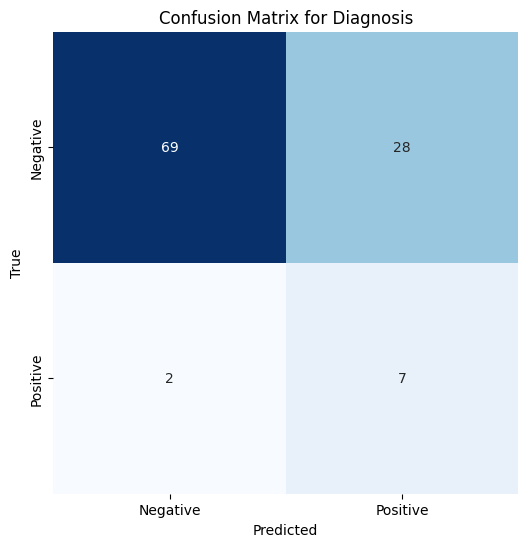

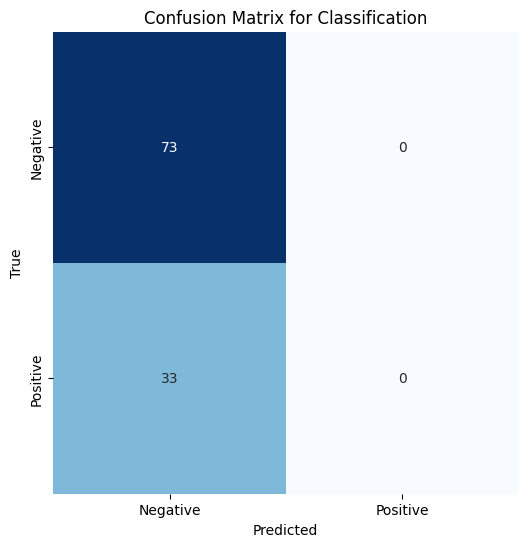

In [141]:
# Example usage
plot_confusion_matrix(y_true_diag, y_pred_diag, "Confusion Matrix for Diagnosis")
plot_confusion_matrix(y_true_class, y_pred_class, "Confusion Matrix for Classification")

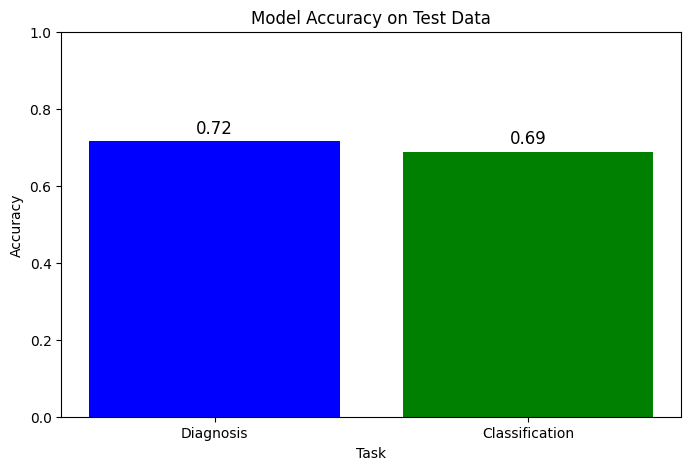

In [143]:
import matplotlib.pyplot as plt

accuracies = {
    "Diagnosis": diag_accuracy,
    "Classification": class_accuracy,
}

plt.figure(figsize=(8, 5))
plt.bar(accuracies.keys(), accuracies.values(), color=["blue", "green"])
plt.title("Model Accuracy on Test Data")
plt.xlabel("Task")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
for i, v in enumerate(accuracies.values()):
    plt.text(i, v + 0.02, f"{v:.2f}", ha="center", fontsize=12)
plt.show()

In [144]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred_prob, title):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()


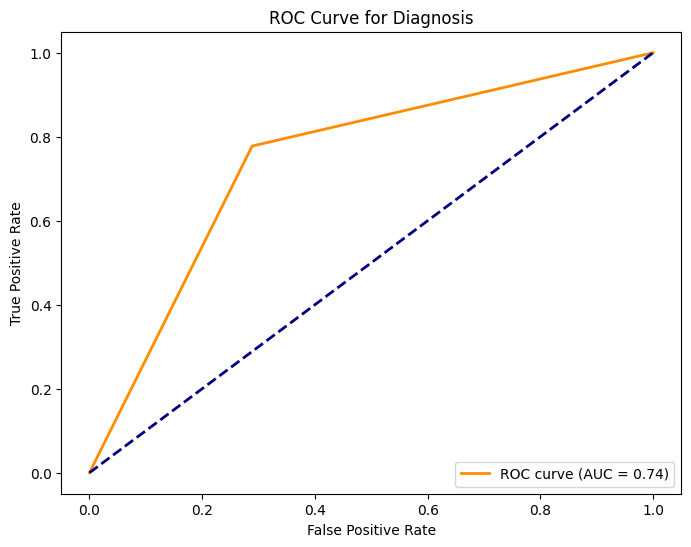

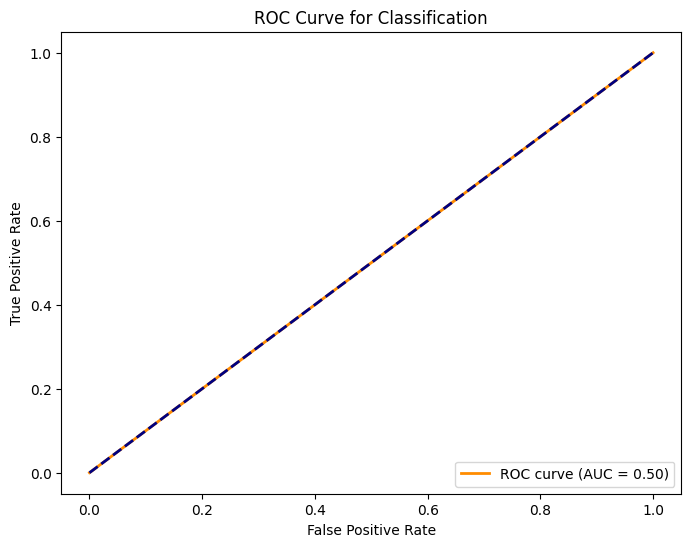

In [145]:
plot_roc_curve(y_true_diag, y_pred_diag, "ROC Curve for Diagnosis")
plot_roc_curve(y_true_class, y_pred_class, "ROC Curve for Classification")

In [147]:
from sklearn.metrics import precision_recall_curve, auc

def plot_precision_recall_curve(y_true, y_pred_prob, title):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color="blue", lw=2, label=f"PR curve (AUC = {pr_auc:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend(loc="upper right")
    plt.show()


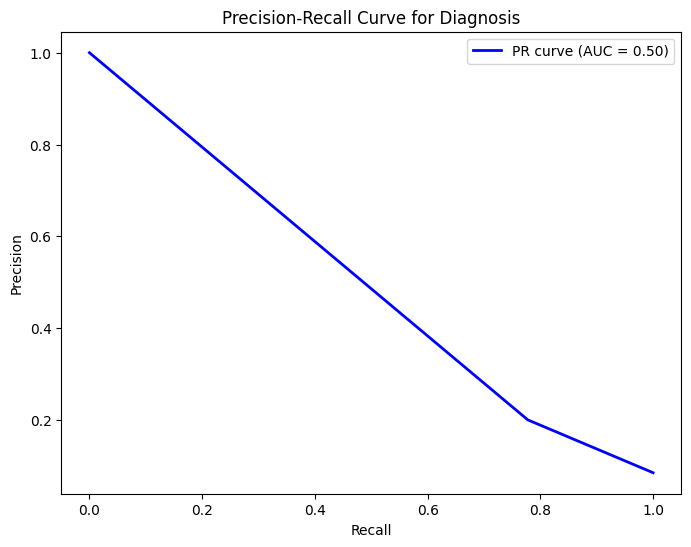

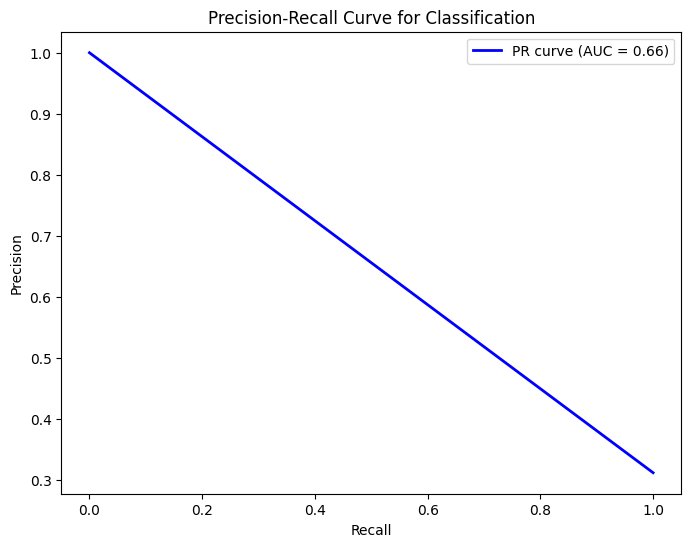

In [149]:
plot_precision_recall_curve(y_true_diag, y_pred_diag, "Precision-Recall Curve for Diagnosis")
plot_precision_recall_curve(y_true_class, y_pred_class, "Precision-Recall Curve for Classification")

In [150]:
from sklearn.metrics import classification_report

print("Classification Report for Diagnosis:")
print(classification_report(y_true_diag, y_pred_diag, target_names=["Negative", "Positive"]))

print("Classification Report for Classification:")
print(classification_report(y_true_class, y_pred_class, target_names=["Negative", "Positive"]))

Classification Report for Diagnosis:
              precision    recall  f1-score   support

    Negative       0.97      0.71      0.82        97
    Positive       0.20      0.78      0.32         9

    accuracy                           0.72       106
   macro avg       0.59      0.74      0.57       106
weighted avg       0.91      0.72      0.78       106

Classification Report for Classification:
              precision    recall  f1-score   support

    Negative       0.69      1.00      0.82        73
    Positive       0.00      0.00      0.00        33

    accuracy                           0.69       106
   macro avg       0.34      0.50      0.41       106
weighted avg       0.47      0.69      0.56       106



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [164]:
data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Diagnosis': [diag_accuracy, diag_precision, diag_recall, diag_f1],
    'Classification': [class_accuracy, class_precision, class_recall, class_f1]
}

summary_table = pd.DataFrame(data)
summary_table


,Metric,Diagnosis,Classification
0,Accuracy,0.716981,0.688679
1,Precision,0.906298,0.474279
2,Recall,0.716981,0.688679
3,F1-Score,0.778700,0.561716
